# Import Libraries

In [3]:
import zipfile
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

# Download and read dataset

In [4]:
!kaggle datasets download -d lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

Dataset URL: https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews
License(s): other
imdb-dataset-of-50k-movie-reviews.zip: Skipping, found more recently modified local copy (use --force to force download)


In [5]:
zip_ref = zipfile.ZipFile('/content/imdb-dataset-of-50k-movie-reviews.zip', 'r')
zip_ref.printdir()
zip_ref.extractall('/content')
zip_ref.close()
df = pd.read_csv("IMDB Dataset.csv")

File Name                                             Modified             Size
IMDB Dataset.csv                               2019-10-19 19:24:58     66212309


# Preprocess the data

In [6]:
def standardize(review):
  review = review.lower().strip()
  review = review.replace("<br>"," ")
  review = review.replace("<br />"," ")
  final = ''

  for c in review:
    if c not in string.punctuation:
      final += c

  return final

def pos_neg(sentiment):
  if sentiment.lower().strip() == "positive":
    return 1
  else:
    return 0

df['review'] = df['review'].apply(standardize)
df['sentiment'] = df['sentiment'].apply(pos_neg)

In [7]:
df2 = df.copy()
#df = df2.copy()
df

,review,sentiment
0,one of the other reviewers has mentioned that ...,1
1,a wonderful little production the filming te...,1
2,i thought this was a wonderful way to spend ti...,1
3,basically theres a family where a little boy j...,0
4,petter matteis love in the time of money is a ...,1
...,...,...
49995,i thought this movie did a down right good job...,1
49996,bad plot bad dialogue bad acting idiotic direc...,0
49997,i am a catholic taught in parochial elementary...,0
49998,im going to have to disagree with the previous...,0


# Split dataset into training, validation and testing datasets

In [8]:
target = df.pop('sentiment')
ds = tf.data.Dataset.from_tensor_slices((df[['review']],target.values))

train_ds = ds.take(40000)
val_ds = ds.skip(40000).take(8000)
test_ds = ds.skip(48000)

train_ds

<_TakeDataset element_spec=(TensorSpec(shape=(1,), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [9]:
train_dataset = train_ds.shuffle(40000, reshuffle_each_iteration = True).batch(64).prefetch(tf.data.AUTOTUNE)
val_dataset = val_ds.batch(64).prefetch(tf.data.AUTOTUNE)
test_dataset = test_ds.batch(64).prefetch(tf.data.AUTOTUNE)


# Build and train model

In [10]:
encoder = tf.keras.layers.TextVectorization(max_tokens=1000)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [11]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(input_dim=len(encoder.get_vocabulary()), output_dim=64, mask_zero=True),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(64, activation='sigmoid'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])


In [12]:
sample_text = standardize('The movie was cool. The the the the animation and the graphics were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]).astype(object))
print(predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
[[0.70345837]]


In [14]:
model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(1e-4), metrics=['accuracy'])
history = model.fit(train_dataset, epochs=8, validation_data=val_dataset, validation_steps=30)

Epoch 1/8
625/625 ━━━━━━━━━━━━━━━━━━━━ 22s 31ms/step - accuracy: 0.5520 - loss: 0.6977 - val_accuracy: 0.7615 - val_loss: 0.5334
Epoch 2/8
625/625 ━━━━━━━━━━━━━━━━━━━━ 39s 31ms/step - accuracy: 0.7640 - loss: 0.5198 - val_accuracy: 0.8281 - val_loss: 0.3897
Epoch 3/8
625/625 ━━━━━━━━━━━━━━━━━━━━ 19s 29ms/step - accuracy: 0.8394 - loss: 0.3763 - val_accuracy: 0.8510 - val_loss: 0.3456
Epoch 4/8
625/625 ━━━━━━━━━━━━━━━━━━━━ 19s 31ms/step - accuracy: 0.8585 - loss: 0.3397 - val_accuracy: 0.8516 - val_loss: 0.3333
Epoch 5/8
625/625 ━━━━━━━━━━━━━━━━━━━━ 18s 29ms/step - accuracy: 0.8628 - loss: 0.3312 - val_accuracy: 0.8562 - val_loss: 0.3322
Epoch 6/8


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


625/625 ━━━━━━━━━━━━━━━━━━━━ 22s 31ms/step - accuracy: 0.8706 - loss: 0.3130 - val_accuracy: 0.8698 - val_loss: 0.3203
Epoch 7/8
625/625 ━━━━━━━━━━━━━━━━━━━━ 18s 29ms/step - accuracy: 0.8726 - loss: 0.3105 - val_accuracy: 0.8573 - val_loss: 0.3356
Epoch 8/8
625/625 ━━━━━━━━━━━━━━━━━━━━ 19s 31ms/step - accuracy: 0.8771 - loss: 0.3037 - val_accuracy: 0.8625 - val_loss: 0.3408


# Test the model and plot its metrics

In [15]:
def test(model, test_ds):
  test_dataset = test_ds.batch(64).prefetch(tf.data.AUTOTUNE)
  test_loss, test_acc = model.evaluate(test_dataset)
  print("Loss :", test_loss, "\nAccuracy : ", test_acc)

test(model, test_ds)

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8637 - loss: 0.3387
Loss : 0.346961110830307 
Accuracy :  0.8495000004768372


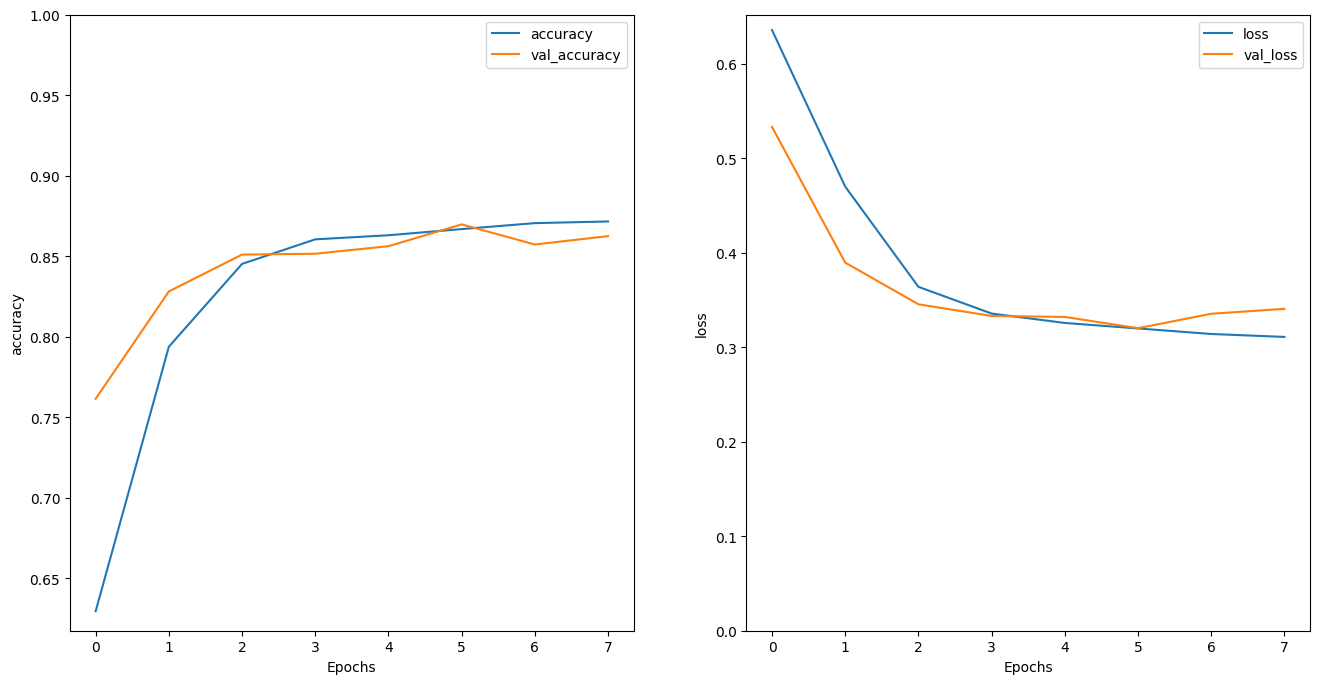

In [16]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

def plot_metrics(history):
  plt.figure(figsize=(16, 8))
  plt.subplot(1, 2, 1)
  plot_graphs(history, 'accuracy')
  plt.ylim(None, 1)
  plt.subplot(1, 2, 2)
  plot_graphs(history, 'loss')
  plt.ylim(0, None)

plot_metrics(history)

In [17]:
'''sample_text = standardize('The movie was really cool. The the the the animation and the graphics were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]).astype(object))
print(predictions)'''
df = df2.copy()
samples = df['review'][45000:]
answers = df['sentiment'][45000:].reset_index()['sentiment']
predictions = pd.Series((model.predict(samples)).reshape(5000))

def convert_bin(x):
  if x >= 0.5:
    return 1
  else:
    return 0

predictions = predictions.apply(convert_bin)
matches = predictions == answers
print("Right :", matches.sum(), "\nTotal :", len(matches), "\nAccuracy :", matches.sum()/len(matches))


157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step
Right : 4263 
Total : 5000 
Accuracy : 0.8526


# Save weights

In [18]:
model.save_weights("model.weights.h5")

from google.colab import files

files.download('model.weights.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [19]:
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir("drive/My Drive/Colab Notebooks/WiDS")

model = model.load_weights("model.weights.h5")

MessageError: Error: credential propagation was unsuccessful